In [1]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

## Extending the example with population data

In [2]:
united = Table.read_table('united.csv')
united

Date,Flight Number,Destination,Delay
6/1/15,73,HNL,257
6/1/15,217,EWR,28
6/1/15,237,STL,-3
6/1/15,250,SAN,0
6/1/15,267,PHL,64
6/1/15,273,SEA,-6
6/1/15,278,SEA,-8
6/1/15,292,EWR,12
6/1/15,300,HNL,20
6/1/15,317,IND,-10


**Question:** Using the bootstrapping simulation methods from class, construct a 90% confidence interval to determine the proportion of flights (at the time that the `united` data was sampled) that either left on time(`Delay = 0`) or left earlier than the scheduled time(`Delay < 0`) because all passengers were already on board. 

In addition to the bootstrapping simulation, include a plot of the simulated data and a line representing the 90% confidence interval. 

*Note: To receive credit for this question, you must use the bootstrapping simulation methods as performed in class. While there may be other methods to simulate or construct this confidence interval, you are being tested on showing that you can perform this specific method.*

In [41]:
# Find a population proportion as at the time the data was collected.

pop_prop_on_time = united.where('Delay', are.below_or_equal_to(0)).num_rows / united.num_rows
pop_prop_on_time

0.4290777576853526

In [42]:
our_sample = united.sample(200, with_replacement=False)
our_sample_prop = our_sample.where('Delay', are.below_or_equal_to(0)).num_rows / our_sample.num_rows

pop_prop_on_time, our_sample_prop

(0.4290777576853526, 0.485)

In [43]:
# Define a function that pulls takes a bootstrap sample of the original sample
# And return the median delay time of the bootstrap sample

def one_bootstrap_prop():
    one_bootstrap_sample = our_sample.sample()
    return one_bootstrap_sample.where('Delay', are.below_or_equal_to(0)).num_rows / one_bootstrap_sample.num_rows

In [44]:
one_bootstrap_prop()

0.455

In [45]:
# Generate the Bootstrap Empirical Distribution of 1000 Sample Proportions

bootstrap_props = make_array()

for i in np.arange(1_000):
    new_prop = one_bootstrap_prop()
    bootstrap_props = np.append(bootstrap_props, new_prop)

In [46]:
left_90 = percentile(5, bootstrap_props)
right_90 = percentile(95, bootstrap_props)

left_90, right_90

(0.42999999999999999, 0.54500000000000004)

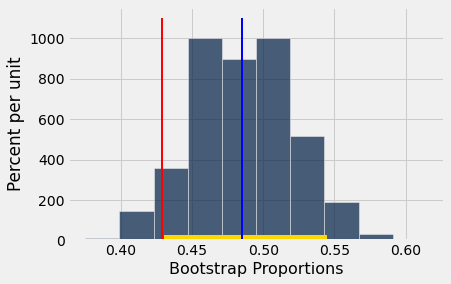

In [50]:
# Visualize the Bootstrap Empirical Distribution of Sample proportions
# Superimpose the population and sample values, as well as the left and right end-points of the 90% confidence interval.

Table().with_column(
    'Bootstrap Proportions', bootstrap_props
).hist('Bootstrap Proportions', bins = 10)

plots.plot([left_90, right_90], [0,0], color="gold",lw=10);
plots.plot([pop_prop_on_time, pop_prop_on_time], [0,11], color="red", lw=2);
plots.plot([our_sample_prop, our_sample_prop], [0,11], color="blue", lw=2);

Based on the data sampled an the simulations conducted, we can be 90% confident that the true but unknown proportion of flights that left early or on time lies between the two values obtained above.

# Summary of steps taken above to compute ONE confidence interval for an "UNKNOWN" population median.


- Step #1: Draw a large random sample from the population(You might be asked to use the entire data set provided to you as the original sample too).
- Step #2: Take bootstrap (re)samples of the large random sample in step #1 and compute the bootstrap sample medians.
- Step #3: Pick off the “middle 95%” interval of all the estimates(by using the percentile function to choose the left and right end-points)

## Side Considerations: What Confidence Level should I choose?

In [47]:
left_95 = percentile(2.5, bootstrap_props)
right_95 = percentile(97.5, bootstrap_props)

left_95, right_95

(0.41499999999999998, 0.55500000000000005)

# Precision Vs Certainty

In [48]:
width_of_90_percent_CI = right_90 - left_90
width_of_95_percent_CI = right_95 -  left_95

width_of_95_percent_CI,  width_of_90_percent_CI

(0.14000000000000007, 0.11500000000000005)

In [49]:
width_of_95_percent_CI > width_of_90_percent_CI

True

## Interpreting Confidence Intervals: Simulation of Simulations ##

What does the sub-topic above mean?

In [10]:
def bootstrap_prop(original_sample, label, replications):
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    target_column = original_sample.select(label)
    flight_props = make_array()
    for i in np.arange(replications):
        one_bootstrap_sample = target_column.sample()
        resampled_prop = one_bootstrap_sample.where(label, are.below_or_equal_to(0)).num_rows / one_bootstrap_sample.num_rows 
        flight_props = np.append(flight_props, resampled_prop)
        
    return flight_props

In [11]:
all_delays = united.select('Delay')

left_ends = make_array()
right_ends = make_array()

# Generate 100 intervals, in the table intervals

for i in np.arange(100):
    one_b_sample = all_delays.sample(200, with_replacement=False)
    proportions = bootstrap_prop(one_b_sample, 'Delay', 1000)
    left_ends = np.append(left_ends, percentile(5, proportions))
    right_ends = np.append(right_ends, percentile(95, proportions))

intervals = Table().with_columns(
    'Left', left_ends,
    'Right', right_ends
)   

In [12]:
intervals

Left,Right
0.385,0.505
0.34,0.46
0.36,0.475
0.375,0.49
0.395,0.515
0.355,0.465
0.36,0.48
0.36,0.48
0.425,0.545
0.38,0.5


In [13]:
# transposes table and labels columns by replication
replication_number = np.ndarray.astype(np.arange(1, 101), str)
intervals2 = Table(replication_number).with_rows(make_array(left_ends, right_ends))
intervals2 

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0.385,0.34,0.36,0.375,0.395,0.355,0.36,0.36,0.425,0.38,0.355,0.375,0.38,0.365,0.425,0.405,0.37,0.335,0.44,0.33,0.36,0.325,0.345,0.28,0.37,0.42,0.44,0.305,0.345,0.36,0.355,0.415,0.37,0.335,0.325,0.35,0.37,0.38,0.37,0.385,0.35,0.38,0.39,0.39,0.345,0.36,0.345,0.385,0.355,0.395,0.37,0.335,0.335,0.365,0.33,0.305,0.375,0.335,0.33,0.35,0.38,0.375,0.38,0.34,0.395,0.39,0.37,0.34,0.405,0.395,0.34,0.365,0.395,0.415,0.35,0.36,0.36,0.46,0.38,0.37,0.355,0.33,0.355,0.345,0.355,0.38,0.35,0.335,0.39,0.37,0.39,0.375,0.375,0.415,0.36,0.4,0.38,0.31,0.415,0.365
0.505,0.46,0.475,0.49,0.515,0.465,0.48,0.48,0.545,0.5,0.475,0.49,0.5,0.475,0.545,0.525,0.485,0.445,0.555,0.445,0.47,0.435,0.46,0.395,0.48,0.53,0.555,0.42,0.46,0.47,0.465,0.525,0.48,0.45,0.435,0.46,0.485,0.5,0.49,0.5,0.46,0.495,0.505,0.5,0.46,0.47,0.465,0.5,0.47,0.51,0.48,0.45,0.445,0.48,0.44,0.42,0.485,0.45,0.44,0.465,0.495,0.495,0.5,0.455,0.51,0.505,0.48,0.46,0.525,0.515,0.45,0.48,0.515,0.52,0.46,0.48,0.475,0.58,0.5,0.48,0.475,0.445,0.47,0.465,0.475,0.49,0.46,0.445,0.505,0.49,0.5,0.495,0.495,0.53,0.47,0.515,0.495,0.42,0.53,0.475


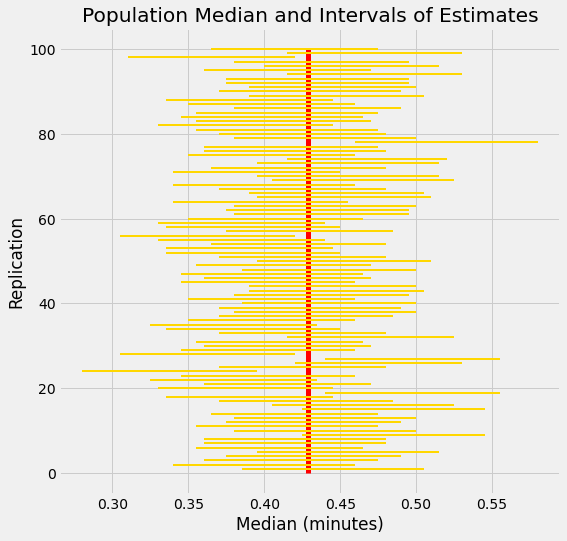

In [14]:
# makes the the plot bigger
plots.figure(figsize=(8,8))

#plot 100 intervals on one plot
for i in np.arange(100):
    ends = intervals2.column(i)
    plots.plot(ends, make_array(i+1, i+1), color='gold', lw=2, zorder=2)
    
plots.plot([pop_prop_on_time, pop_prop_on_time], make_array(0, 100), color='red', lw=5, zorder=1)
plots.xlabel('Median (minutes)')
plots.ylabel('Replication')
plots.title('Population Median and Intervals of Estimates');

# Communicating your findings correctly:

About $90 \%$ of all random samples, eash of size 200 flights, would result in a $90 \%$ confidence interval that contained the population percentage/proportion of flights that were not delayed past the scheduled time of flight. 

# Take-Home Example: Confidence Intervals  based on Bootstrap Resamples

## Another Example: Estimating the Mean Maternal Age

**Question:** Using the bootstrapping simulation methods from class, construct a 95% confidence interval to determine the mean maternal age(as of the time when the `births` data was sampled).

In addition to the bootstrapping simulation, include a plot of the simulated data and a line representing the 95% confidence interval. 

*Note: To receive credit for this question, you must use the bootstrapping simulation methods as performed in class. While there may be other methods to simulate or construct this confidence interval, you are being tested on showing that you can perform this specific method.*

In [51]:
# This time we have a sample, but no population data!
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


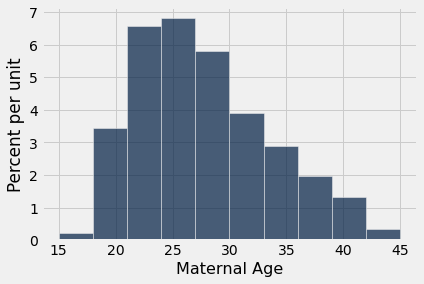

In [52]:
# sample distribution

births.hist('Maternal Age')

In [53]:
# sample mean maternal age

mean_age = np.mean(births.column('Maternal Age'))
mean_age

27.228279386712096

In [54]:
# samples with replacement from our sample
# returns the mean maternal age of this bootstrap sample

def one_bootstrap_mean():
    return np.mean(births.sample().column('Maternal Age'))

In [55]:
bootstrap_means = make_array()

for i in np.arange(1000):
    new_mean = one_bootstrap_mean()
    bootstrap_means = np.append(bootstrap_means, new_mean)

# Determine the bounds for the middle 95% of bootstrap sample mean maternal ages
    
left = percentile(2.5, bootstrap_means)
right = percentile(97.5, bootstrap_means)

We have 95% confidence that the mean maternal age is in the interval from 26.902 to 27.548 years old.


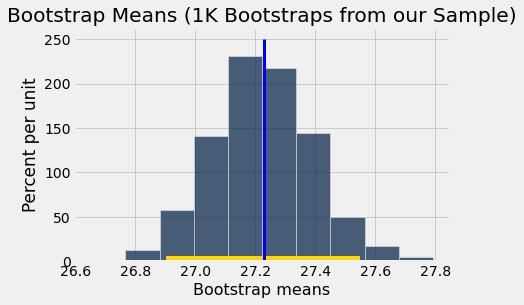

In [56]:
Table().with_column('Bootstrap means', bootstrap_means).hist()

plots.plot([left,right], [0,0], color="gold", lw=10, zorder=1);
plots.plot([mean_age,mean_age], [0,2.5], color="blue", lw=3, zorder=1);
plots.title('Bootstrap Means (1K Bootstraps from our Sample)');

print("We have 95% confidence that the mean maternal age is in the interval from", 
      np.round(left, 3),
      "to",
      np.round(right, 3),
      'years old.'
     )

In [57]:
def bootstrap_mean(original_sample, label, replications):
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    target_column = original_sample.select(label)
    means = make_array()
    for i in np.arange(replications):
        bootstrap_sample = target_column.sample()
        resampled_mean = np.mean(bootstrap_sample.column(label)) 
        means = np.append(means, resampled_mean)
        
    return means

In [58]:
all_ages = births.select('Maternal Age')

# Generate 100 intervals, in the table intervals
age_left_ends = make_array()
age_right_ends = make_array()

for i in np.arange(100):
    age_sample = all_ages.sample(100, with_replacement=False)
    bootstrap_sample_mean = bootstrap_mean(age_sample, 'Maternal Age', 1000)
    age_left_ends = np.append(age_left_ends, percentile(2.5, bootstrap_sample_mean))
    age_right_ends = np.append(age_right_ends, percentile(97.5, bootstrap_sample_mean))

intervals = Table().with_columns(
    'Left', age_left_ends,
    'Right', age_right_ends
)   

In [59]:
# transposes table and labels columns by replication
replication_number = np.ndarray.astype(np.arange(1, 101), str)
intervals_age = Table(replication_number).with_rows(make_array(age_left_ends, age_right_ends))
intervals_age

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
26.45,26.1,26.29,26.18,25.59,26.05,25.42,26.35,26.74,25.99,25.85,25.67,26.09,26.38,26.4,25.76,26.34,26.08,26.06,25.21,26.9,25.22,25.79,26.06,26.05,26.19,26.53,26.63,26.45,26.31,26.57,25.18,26.59,25.94,25.84,26.55,26.99,26.31,26.48,26.59,25.79,26.06,26.3,25.32,26.1,26.28,25.54,25.24,25.69,25.55,25.47,25.39,25.6,25.73,26.19,26.22,26.21,26.16,25.83,25.74,26.31,26.49,25.49,26.5,26.28,26.06,25.92,26.27,26.42,26.1,24.9,26.45,26.27,26.16,25.79,24.97,26.75,26.46,25.62,25.59,26.26,26.56,25.94,25.83,25.79,26.94,26.22,25.19,26.89,26.3,25.91,26.71,25.78,25.18,26.34,26.26,26.46,25.36,25.62,26.77
28.85,28.4,28.74,28.37,27.98,28.7,27.74,28.68,29.14,28.3,28.18,27.89,28.15,28.56,28.73,27.87,28.37,28.41,28.4,27.56,29.4,27.49,28.07,28.43,28.13,28.27,28.87,28.91,28.68,28.77,28.72,27.29,29.14,28.35,28.16,29.27,29.36,28.39,28.8,28.82,27.9,28.16,28.62,27.57,28.3,28.33,27.56,27.38,27.69,27.85,27.76,27.38,28.13,27.74,28.49,28.65,28.64,28.63,28.05,28.25,28.74,28.94,27.75,28.79,28.95,28.29,28.17,28.52,28.9,28.34,27,28.61,28.46,28.29,28.04,27.4,29.27,28.94,27.92,27.62,28.36,28.87,28.2,28.32,28.18,29.18,28.48,27.33,29.36,28.66,28.42,28.74,28.19,27.26,28.83,28.5,28.74,27.58,27.67,29.22


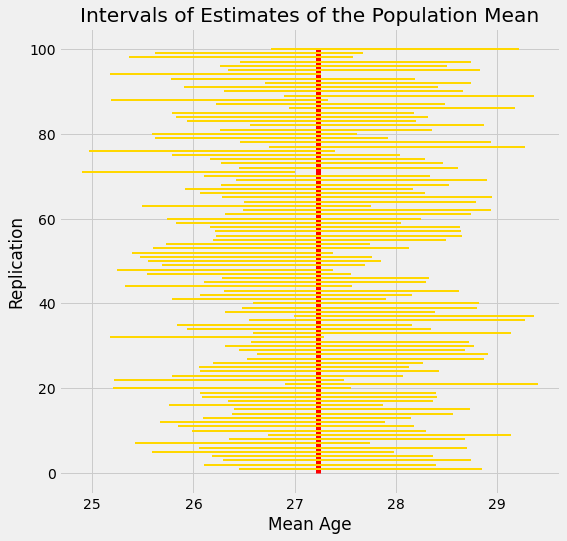

In [60]:
# makes the the plot bigger
plots.figure(figsize=(8,8))

#plot 100 intervals on one plot
for i in np.arange(100):
    ends = intervals_age.column(i)
    plots.plot(ends, make_array(i+1, i+1), color='gold', lw=2, zorder=2)
    
plots.plot([mean_age, mean_age], make_array(0, 100), color='red', lw=5, zorder=1)
plots.xlabel('Mean Age')
plots.ylabel('Replication')
plots.title('Intervals of Estimates of the Population Mean');